<a href="https://colab.research.google.com/github/ishitamehta028/MLMapper/blob/main/MESSENGER_LunarAlbedo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Predicting the Lunar Albedo based on Chemical Composition
### **Ishita Mehta**

My algorithm for choice here is the XGBoost Regressor. It consistently outperforms other classifiers and is highly optimizable.

---


Here, we have multiple maps which can be divided in two categories: 
  
*   Albedo map
*   Element composition maps

For error evaluation metric, I have taken MSE (Mean Squared Error), MAE (Mean Absolute Error)and R2 Square. I have not used RMSE since it can be highly sensitive to outliers.


R square is the only metric here that considers the overfitting problem.



The model achieves the following evaluation metrics : 

1.   MSE : **0.0009591354225154232**
2.   MAE :  **0.023769456720090884**
3.   R_2 score : **0.5735485870219628**





In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

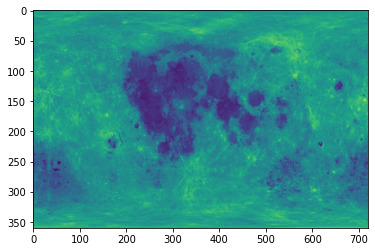

In [ ]:
# reading datasets into dataframes 

albedo = pd.read_csv("/content/Albedo_Map.csv", header = None, sep=',')

Fe_map = pd.read_csv("/content/LPFe_Map.csv", header = None, sep=',')
K_map = pd.read_csv("/content/LPK_Map.csv", header = None, sep=',')
Th_map = pd.read_csv("/content/LPTh_Map.csv", header = None, sep=',')
Ti_map = pd.read_csv("/content/LPTi_Map.csv", header = None, sep=',')

albedo.head()



plt.imshow(albedo, aspect = 'auto')

In [ ]:
def split(df) : 
  # 720 columns, for each left and right we take 360 col 
  # and split the maps
  left = df.iloc[:, 0:360].values
  right = df.iloc[:, 360:720].values

  plt.subplot(1, 2, 1)
  plt.imshow(left, aspect = 'auto')
  plt.title("Left")

  plt.subplot(1, 2, 2)
  plt.imshow(right, aspect = 'auto')
  plt.title("Right")
  return left, right

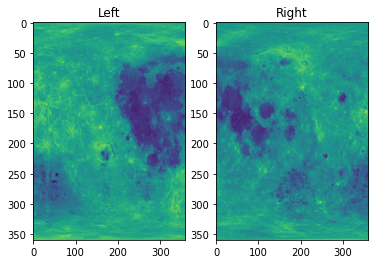

In [ ]:
alb_l,alb_r = split(albedo)

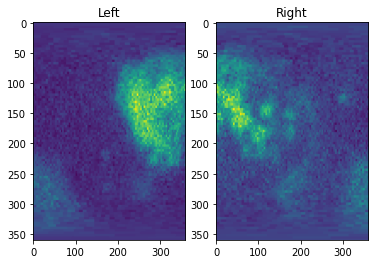

In [ ]:
l_fe, r_fe = split(Fe_map)

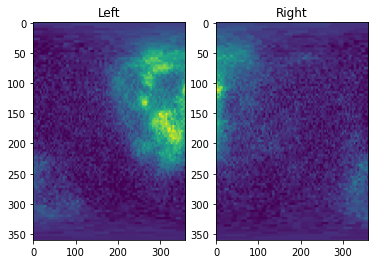

In [ ]:
l_k, r_k = split(K_map)

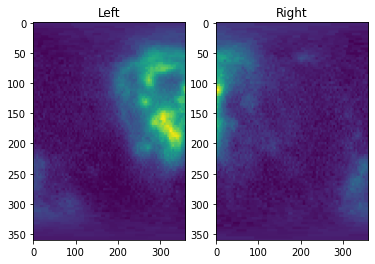

In [ ]:
l_th, r_th = split(Th_map)

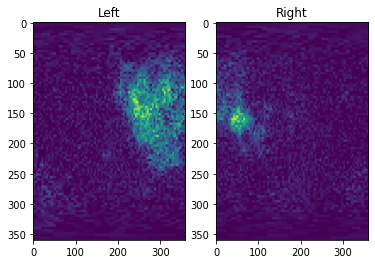

In [ ]:
l_ti, r_ti = split(Ti_map)

In [ ]:
def dataframe(albedo, fe, k ,th, ti) : 
  
  X = pd.DataFrame()
  composition = [fe, k, th, ti]
  for maps in composition : 
    map = pd.Series(maps.ravel())
    X = pd.concat([X, map], axis = 1)
  X.columns = ['Fe', 'K', 'Th', 'Ti']

  y = albedo.ravel().reshape(-1,1)

  return X, y 

In [ ]:
X_train_set ,y_train = dataframe(alb_l, l_fe, l_k, l_th, l_ti )
X_test_set, y_test = dataframe(alb_r, r_fe, r_k , r_th, r_ti )

X_test_set

,Fe,K,Th,Ti
0,4.04409,788.81,1.26750,0.190154
1,4.04409,788.81,1.26750,0.190154
2,4.04409,788.81,1.26750,0.190154
3,4.04409,788.81,1.26750,0.190154
4,4.04409,788.81,1.26750,0.190154
...,...,...,...,...
129595,3.82753,455.07,0.79856,0.112137
129596,3.82753,455.07,0.79856,0.112137
129597,3.82753,455.07,0.79856,0.112137
129598,3.82753,455.07,0.79856,0.112137


In [ ]:
def eval(prediction) :
  eval = ['rmse', 'mse', 'r2score']
  error = []
  error.append(mean_squared_error(y_test, prediction))
  error.append(mean_absolute_error(y_test, prediction))
  error.append(r2_score(y_test, prediction)) 
  print("Error MSE, MAE, R2score : ",error, sep = '\n')

In [ ]:
def plot_prediction(pred) :
  prediction = pred.reshape(alb_r.shape)
  fig,a =  plt.subplots(1,2 , sharex='col', sharey='row' )
  plt.subplots_adjust()

# Y_test Data Albedo
  plt.subplot(1, 2, 1)
  plt.tight_layout()
  plt.imshow(alb_r)
  plt.title("True Albedo")

# Predicted Albedo
  plt.subplot(1, 2, 2)
  plt.imshow(prediction, cmap=plt.cm.get_cmap('PuBuGn',10))
  plt.title("Predicted Albedo")
  #sm = plt.cm.ScalarMappable(cmap = 'PuBuGn')
  #fig.colorbar(sm, orientation="horizontal")
  
  
# 1-D Histogrm plotted for Brightness of different pixels
  plt.figure()
  sns.distplot(pred, bins = 10, hist = True, color= 'yellow')
  sns.distplot(alb_r, color = 'green')
  plt.title('Brightness', fontweight="bold")
  plt.xlabel('Pixel Brightness', fontweight="bold")
  plt.ylabel('Pixel Count', fontweight="bold")
  plt.legend(['Predicted Albedo', 'True Albedo'])
  plt.show()
  
   

# Resdidual plot to show the difference of pixel intensities
  plt.figure()
  residual_plot = prediction - alb_r
  plt.imshow(residual_plot, cmap='Greys_r')
  plt.title('Residual Plot', fontweight = "bold")


# XGBoost Regressor Model
This is a suitable model owing to multiple factors like speed and performance, it is comparatively faster than other ensemble classifiers.The core algorithm is parallelizable and a variety of tuning parameters to better train the Model and is highly regularizable.
Here, Squared Loss regression is used


In [ ]:
model = xgb.XGBRegressor(objective ='reg:squarederror', base_score = 0.5, learning_rate = 0.04, n_estimators = 80, eta= 0.2, max_depth = 6, alpha = 2)

# Training the model on the left side of the Moon
model.fit(X_train_set, y_train) 

#Predicting on the right side of the moon using the Chemical composition
prediction = model.predict(X_test_set) 
print("Predicted Albedo :", prediction)
eval(prediction)

Predicted Albedo : [0.3303641  0.3303641  0.3303641  ... 0.34407705 0.34407705 0.34407705]
Error MSE, MAE, R2score : 
[0.0009591354225154232, 0.023769456720090884, 0.5735485870219628]


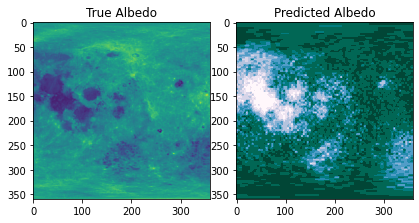

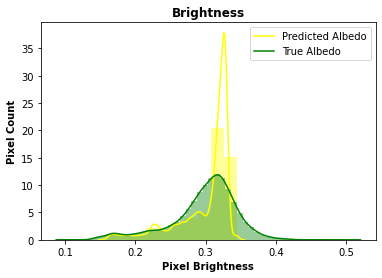

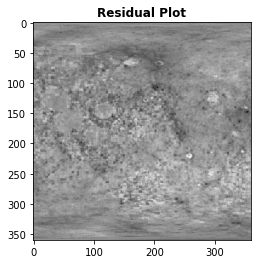

In [ ]:
plot_prediction(prediction)